# PPG Peak Detection without Ground‑Truth Labels

https://iopscience.iop.org/article/10.1088/1361-6579/adb89e

In [5]:
import sys
import glob
import re
import os
import math

project_root = os.path.abspath("../heart_rhythm_analysis")  # Adjust if notebook is nested deeper
if project_root not in sys.path:
    sys.path.append(project_root)

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader,random_split
from torchinfo import summary

from model.unet1d import UNet1D
from utils.utils import PPGWindow,pseudo_peak_vector,scale_signal,find_sliding_window

In [4]:
sys.path

['/Users/shayanriyaz/miniconda3/envs/heart_rhythm_applications/lib/python312.zip',
 '/Users/shayanriyaz/miniconda3/envs/heart_rhythm_applications/lib/python3.12',
 '/Users/shayanriyaz/miniconda3/envs/heart_rhythm_applications/lib/python3.12/lib-dynload',
 '',
 '/Users/shayanriyaz/.local/lib/python3.12/site-packages',
 '/Users/shayanriyaz/miniconda3/envs/heart_rhythm_applications/lib/python3.12/site-packages',
 '__editable__.heart_rhythm_analysis-0.1.0.finder.__path_hook__',
 '/Users/shayanriyaz/Documents/Projects/heart_rhythm_analysis']

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps'
print('Device:', device)
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"    # avoid crashes on odd ops
torch.mps.empty_cache()                            # call between val runs

Device: mps


In [3]:
# ----------------------------- configuration -----------------------------

# H5_PATH = os.path.join('data',FOLDER_PATH,'mimic_non_af_data.h5')  # update if your file lives elsewhere
WIN_SEC = 30                      # window length in seconds
FS_ORIGINAL = 125
DEC_FACTOR = 6
FS = round(FS_ORIGINAL/DEC_FACTOR,2)                  # Hz (dataset‑wide constant)
print(FS)
WIN_LEN = int(round(WIN_SEC * FS))            # 3_750 samples
BATCH   = 32
EPOCHS  = 200                       # demo; increase to 30+ for real training

VAR_MULT=500

FOLDER_PATH = 'length_full'
DEVELOPMENT_DATA_PATH = os.path.join('..','data','development_dataset',FOLDER_PATH)
TRAIN_LOADER_PATH = os.path.join(DEVELOPMENT_DATA_PATH,'train_ds.pkl');
VAL_LOADER_PATH = os.path.join(DEVELOPMENT_DATA_PATH,'val_ds.pkl');
TEST_LOADER_PATH =os.path.join(DEVELOPMENT_DATA_PATH,'test_ds.pkl');

20.83


In [1]:
best_config = find_sliding_window(WIN_LEN,target_windows = 5, overlap=25)
scale_type = "norm"


if not os.path.exists(TRAIN_LOADER_PATH):
    TRAIN_PATH = f"../data/processed/{FOLDER_PATH}/train_ds.h5"
    train_ds = PPGWindow(TRAIN_PATH,best_config=best_config,scale_type=scale_type)

    if not os.path.exists(DEVELOPMENT_DATA_PATH):
        os.mkdir(DEVELOPMENT_DATA_PATH)
        
    torch.save(train_ds, TRAIN_LOADER_PATH)
else:
    train_ds = torch.load(TRAIN_LOADER_PATH, weights_only=False)

VAL_FRAC = 0.20               # 10 % of the *virtual* samples
n_total  = len(train_ds)
n_val    = int(n_total * VAL_FRAC)
n_train  = n_total - n_val

train_ds, val_ds = random_split(
    train_ds,
    lengths=[n_train, n_val],
    generator=torch.Generator().manual_seed(42)   # reproducible
)

train_loader = DataLoader(train_ds, batch_size=BATCH,
                        shuffle=True, num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH,
                        shuffle=True, num_workers=0, pin_memory=False)

print('Dataset ready. Example batch shapes:')
x, y,_,_= next(iter(train_loader))
print(x.shape, y.shape)   # (B, 1, 3750) (B, 3750)



NameError: name 'find_sliding_window' is not defined

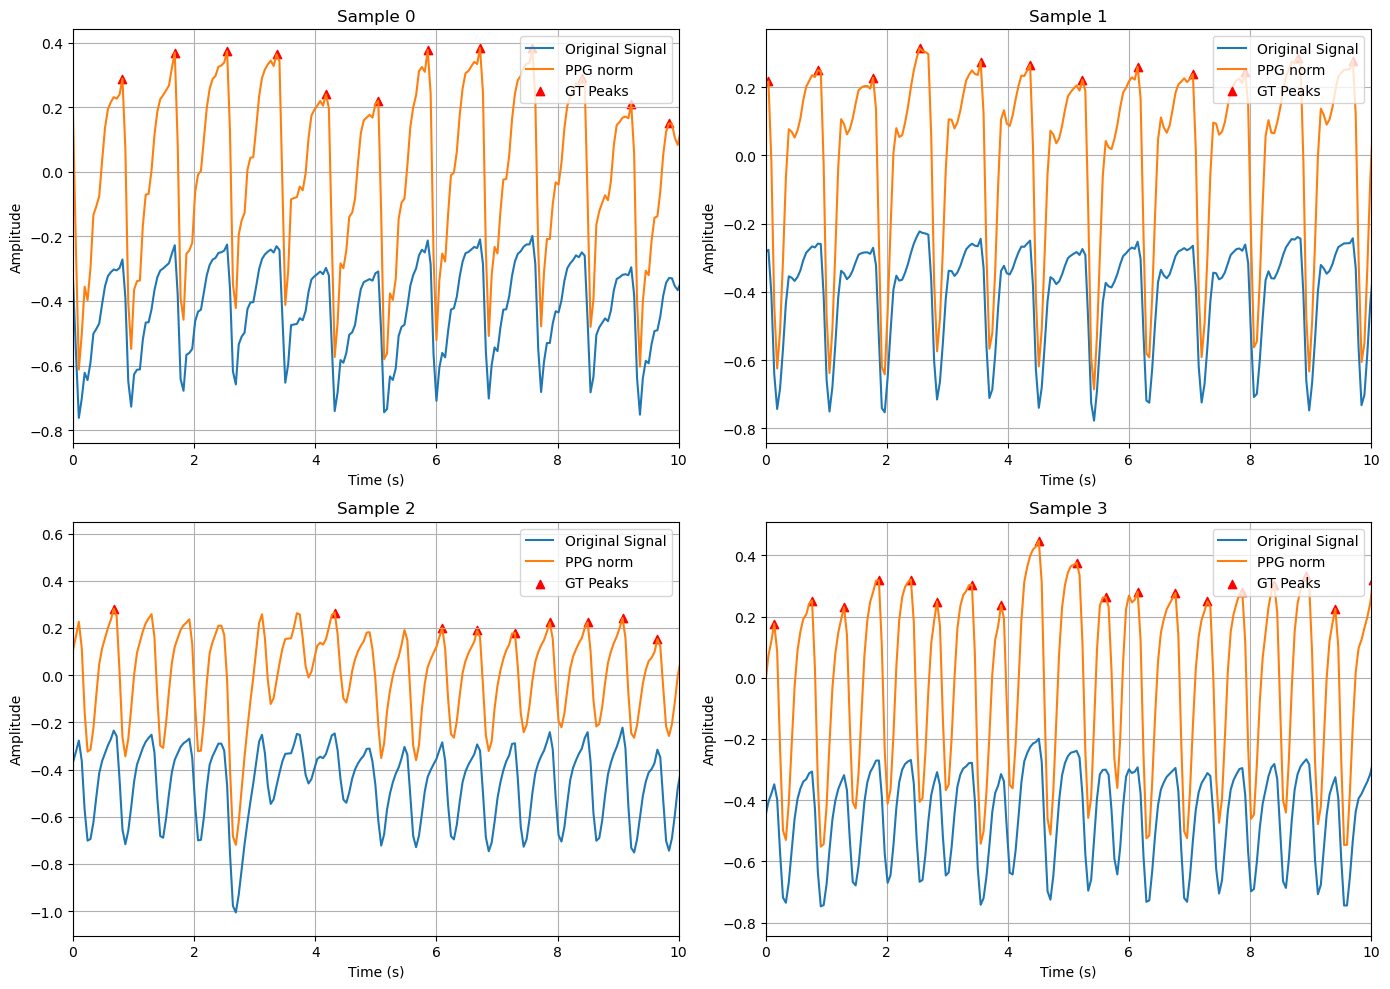

In [5]:
B, _, L = x.shape

# How many to plot
n_plot = min(4, B)
cols   = math.ceil(math.sqrt(n_plot))
rows   = math.ceil(n_plot / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*7, rows*5), squeeze=False)

for i in range(n_plot):
    x, y,original_signal,_ = next(iter(train_loader))
    ax = axes[i//cols][i%cols]
    seg = scale_signal(x[0,0], best_config,method = scale_type)

    # call your function instead of hp.process
    y = pseudo_peak_vector(seg, fs=FS)
    peaks = np.nonzero(y > 0)[0]
    t = np.arange(len(seg)) / FS
    input_signal = original_signal[0,0]*-1
    seg *= -1


    ax.plot(t,original_signal[0,0]*-1,label='Original Signal')
    ax.plot(t, seg, label=f'PPG {scale_type}')
    ax.scatter(t[peaks], seg[peaks], c='r', marker='^', label='GT Peaks')
    ax.set_title(f'Sample {i}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.legend(loc='upper right')
    ax.grid()
    ax.set_xlim(0,10)

plt.tight_layout()
plt.show()

In [6]:
class EarlyStoppingBasic:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def step(self, current_loss):
        if self.best_loss is None or current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

In [7]:
# 1) Gather all labels from your training set (flattened)
counts = torch.zeros(2, dtype=torch.long)
for _, yb, _, _ in train_loader:
    flat = yb.view(-1).long()                     # ensure integer dtype
    c = torch.bincount(flat, minlength=2)         # c[0]=#zeros, c[1]=#ones
    counts += c
neg, pos = counts[0].item(), counts[1].item()
print(f"neg={neg}, pos={pos}")


alpha = 0.5
pos_weight = (neg/pos)**alpha   # ≃ 5.0

print(pos_weight)
# 3) Build your pos_weight from that ratio
pos_weight = torch.tensor([pos_weight], dtype=torch.float32, device=device)

# 4) Create your loss once, using that pos_weight
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

scaler = torch.amp.GradScaler(enabled=False)       # autocast handles bfloat16

neg=6486344, pos=263656
4.959994092983727


In [ ]:
model = UNet1D().to(device)
print(summary(model, input_size=(1,1, WIN_LEN)))

model = UNet1D().to(device)

LEARNING_RATE = 3e-5;
optim = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim,'min',factor=0.1,       
    patience=3,      
    threshold=1e-3,   
    threshold_mode='rel'  
)
early_stopper = EarlyStoppingBasic(patience=5, min_delta=1e-3)

# Reinforcement Learning
baseline = torch.tensor(0., device=device)
MIN_RR = 0.3
MAX_RR = 2

WINDOW_SEC   = 30
MAX_BPM      = 240
MAX_PEAKS    = int(MAX_BPM/60 * WINDOW_SEC)   # = 120
MAX_INTERVAL = MAX_PEAKS - 1                  # = 119

def compute_reward(actions,positions, fs=FS,window_sec=WINDOW_SEC,max_bpm = MAX_BPM,
                   min_rr=MIN_RR, max_rr=MAX_RR,max_interval=MAX_INTERVAL) -> float:
    # # 2) compute rewards in pure tensor ops
    # #    positions and min/max constants should be defined at module scope
    mask      = actions.to(torch.bool)                                             # (B, L)
    # mask[:,1:] * positions[1:] picks out the time of each “next” peak
    pairs = mask[:,:-1] & mask[:,1:]
    deltas = positions[1:] - positions[:-1]            # (L-1)
    reward_vals = torch.where(deltas<min_rr, -1.0,
                    torch.where(deltas>max_rr, -0.1, 1.0))
    reward_matrix = reward_vals[None] * pairs.float()  # broadcast to (B,L-1)
    raw_r            = reward_matrix.sum(dim=1)                    # (B,)
    clipped          = raw_r.clamp(-max_interval, max_interval)  # (B,)
    rewards          = clipped / max_interval                     # (B,)
    return rewards

# 2) Pretrain then anneal RL term
PRETRAIN_EPOCHS   = 10
RL_ANNEAL_EPOCHS  = 10
RL_BETA_MAX       = 0.2

baseline = torch.tensor(0., device=device)
def get_beta(epoch: int) -> float:
    if epoch <= PRETRAIN_EPOCHS:
        return 0.0
    t = min(epoch - PRETRAIN_EPOCHS, RL_ANNEAL_EPOCHS)
    return RL_BETA_MAX * (t / RL_ANNEAL_EPOCHS)

Layer (type:depth-idx)                   Output Shape              Param #
UNet1D                                   [1, 625]                  --
├─ModuleList: 1-1                        --                        --
│    └─ConvBlock: 2-1                    [1, 16, 625]              --
│    │    └─Sequential: 3-1              [1, 16, 625]              2,544
│    └─ConvBlock: 2-2                    [1, 32, 312]              --
│    │    └─Sequential: 3-2              [1, 32, 312]              14,016
│    └─ConvBlock: 2-3                    [1, 64, 156]              --
│    │    └─Sequential: 3-3              [1, 64, 156]              55,680
│    └─ConvBlock: 2-4                    [1, 128, 78]              --
│    │    └─Sequential: 3-4              [1, 128, 78]              221,952
├─ConvBlock: 1-2                         [1, 128, 39]              --
│    └─Sequential: 2-5                   [1, 128, 39]              --
│    │    └─Conv1d: 3-5                  [1, 128, 39]              14

In [ ]:
bSaveCheckPoint = True
# ─── Config ────────────────────────────────────────────────────────────────
MODEL_NUM = "nn_w_rl2"
CKPT_DIR     = f"../trained_model/checkpoints/{MODEL_NUM}/"
if not os.path.exists(CKPT_DIR):
    os.mkdir(CKPT_DIR)
CKPT_PATTERN = os.path.join(CKPT_DIR, f"ckpt_epoch_{MODEL_NUM}_*.pth")
SAVE_EVERY   = 5         # save every N epochs
RESUME       = True       # flip to False if you never want to resume
device       = "mps" if torch.backends.mps.is_available() else "cpu"

# ─── Helper: find latest checkpoint ────────────────────────────────────────
def find_latest_checkpoint(pattern=CKPT_PATTERN):
    files = glob.glob(pattern)
    if not files:
        return None
    # extract epoch number from filename
    epochs = [(int(re.search(rf"ckpt_epoch_{MODEL_NUM}_(\d+)\.pth$", f).group(1)), f)
              for f in files if re.search(rf"ckpt_epoch_{MODEL_NUM}_(\d+)\.pth$", f)]
    if not epochs:
        return None
    return max(epochs, key=lambda x: x[0])  # (epoch, filepath)

# ─── On startup: optionally resume ─────────────────────────────────────────
start_epoch = 1
if RESUME:
    latest = find_latest_checkpoint()
    if latest is not None:
        start_epoch, path = latest
        print(f"Resuming from checkpoint epoch {start_epoch}: {path}")
        ckpt = torch.load(path, map_location=device)
        print(ckpt)
        model.load_state_dict(ckpt["model"])
        optim.load_state_dict(ckpt["optim"])
        scheduler.load_state_dict(ckpt["scheduler"])
        baseline = ckpt.get("baseline", baseline)
        ckpt.get("bas")
        # if you saved RNG:
        # torch.random.set_rng_state(ckpt["rng"])
        start_epoch += 1  # next epoch to run
start_epoch

1

In [10]:
RL_START_EPOCH      = 10   # don’t do any RL until after epoch 5
RL_CALL_EPOCH_FREQ  = 3    # once you’ve started, run RL only once every 3 epochs

all_train_loss = []
all_val_loss = []
all_rl_loss = []
all_avg_rewards = []

positions = torch.arange(L, device=device, dtype=torch.float32) / FS
# ----------------------------- training ----------------------------------
# plt.figure()

for epoch in range(start_epoch, EPOCHS+1):
    model.train()
    cumulative_train_loss = 0.0
    cumulative_val_loss = 0.0
    cumulative_rl_loss = 0.0

    total_batches = 0
    epoch_reward = 0.0
    do_rl_epoch = (epoch > RL_START_EPOCH) and ((epoch - RL_START_EPOCH) % RL_CALL_EPOCH_FREQ == 0)
    beta = get_beta(epoch)
    
    for xb, yb,_,_ in tqdm(train_loader, desc=f'Train \t| Epoch {epoch}/{EPOCHS}'):
        xb, yb = xb.to(device,non_blocking=True), yb.to(device,non_blocking=True)
        optim.zero_grad(set_to_none=True) 

        with torch.autocast("mps", dtype=torch.bfloat16):
            logits = model(xb).float()                 # autocast returns bf16
            sup_loss   = criterion(logits, yb)
            
        rl_loss = torch.tensor(0.0, device=device)

        if  do_rl_epoch and beta > 0.0:
            # # ----------------------- Reinforcement Learning -----------------------
            probs = torch.sigmoid(logits).clamp(1e-6, 1-1e-6)
            dist = torch.distributions.Bernoulli(probs)
            actions = dist.sample()

            rewards = compute_reward(actions,positions, fs=FS,window_sec=WINDOW_SEC,max_bpm = MAX_BPM,
                   min_rr=MIN_RR, max_rr=MAX_RR,max_interval=MAX_INTERVAL)
            
            # --- build the RL loss ----------------------------------------
            logps   = dist.log_prob(actions).sum(dim=1)   # (B,)
            adv     = rewards - baseline
            rl_loss = -(logps * adv).mean()

            with torch.no_grad():
                baseline.mul_(0.9).add_(0.1 * rewards.mean())

            total_batches += 1
            epoch_reward += rewards.mean().item()
            cumulative_rl_loss += rl_loss.item() * xb.size(0)
       
        # total loss and backward 
        loss = sup_loss + beta*rl_loss
        if torch.isnan(sup_loss): raise ValueError('NaN in combines loss')

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optim.step()

        cumulative_train_loss += sup_loss.item() * xb.size(0)

    mean_rl = cumulative_rl_loss / len(train_loader.dataset)
    mean_train = cumulative_train_loss / (len(train_loader.dataset))
    avg_reward = (epoch_reward / total_batches) if total_batches > 0 else float("nan")
    all_avg_rewards.append(avg_reward)

    # ───────────────── validation ─────────────────────────────────────
    model.eval()
    with torch.no_grad():
        for xb, yb,_,_ in tqdm(val_loader, desc=f'Val \t| Epoch {epoch}/{EPOCHS}'):
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            with torch.autocast("mps", dtype=torch.bfloat16):
                logits = model(xb).float()
                validation_loss   = criterion(logits, yb)
            if torch.isnan(validation_loss): raise ValueError('NaN loss')
            cumulative_val_loss += validation_loss.item() * xb.size(0)

    mean_val = cumulative_val_loss / (len(val_loader.dataset))

    # ───────────────── bookkeeping ────────────────────────────────────
    scheduler.step(mean_val)         # if ReduceLROnPlateau
    stop = early_stopper.step(mean_val)

    all_train_loss.append(mean_train)
    all_rl_loss.append(mean_rl)
    all_val_loss.append(mean_val)


    print(f"Epoch {epoch:02d} | "
          f"train = {mean_train:.4f}  | "
          f"val = {mean_val:.4f} | "
          f"beta = {beta:.4f} | "
          f"rl_loss = {mean_rl:.4f} | "
          f"avg_reward={avg_reward:.4f}  | "
          f"lr={optim.param_groups[0]['lr']:.1e}")

    # # ─── Save checkpoint every N epochs ──────────────────────────────────
    if (epoch % SAVE_EVERY == 0) and (bSaveCheckPoint):
        os.makedirs(CKPT_DIR, exist_ok=True)
        ckpt_path = os.path.join(CKPT_DIR, f"ckpt_epoch_{MODEL_NUM}_{epoch}.pth")
        torch.save({
            "epoch":     epoch,
            "model":     model.state_dict(),
            "optim":     optim.state_dict(),
            "scheduler": scheduler.state_dict(),
            "baseline":  baseline,
            # "rng":       torch.random.get_rng_state(),
        }, ckpt_path)
        print(f"Saved checkpoint: {ckpt_path}")

    if stop:
        print("Early stopping triggered at epoch", epoch+1)
        break

    torch.mps.empty_cache() 



Train 	| Epoch 1/200: 100%|██████████| 338/338 [01:43<00:00,  3.27it/s]
Val 	| Epoch 1/200: 100%|██████████| 85/85 [00:18<00:00,  4.71it/s]


Epoch 01 | train = 0.8011  | val = 0.7391 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 2/200: 100%|██████████| 338/338 [01:43<00:00,  3.25it/s]
Val 	| Epoch 2/200: 100%|██████████| 85/85 [00:17<00:00,  4.72it/s]


Epoch 02 | train = 0.6985  | val = 0.6865 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 3/200: 100%|██████████| 338/338 [01:43<00:00,  3.25it/s]
Val 	| Epoch 3/200: 100%|██████████| 85/85 [00:17<00:00,  4.96it/s]


Epoch 03 | train = 0.6526  | val = 0.6357 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 4/200: 100%|██████████| 338/338 [01:44<00:00,  3.23it/s]
Val 	| Epoch 4/200: 100%|██████████| 85/85 [00:17<00:00,  4.87it/s]


Epoch 04 | train = 0.6146  | val = 0.5983 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 5/200: 100%|██████████| 338/338 [01:43<00:00,  3.26it/s]
Val 	| Epoch 5/200: 100%|██████████| 85/85 [00:17<00:00,  4.86it/s]


Epoch 05 | train = 0.5809  | val = 0.5659 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/ckpt_epoch_nn_w_rl2_5.pth


Train 	| Epoch 6/200: 100%|██████████| 338/338 [01:40<00:00,  3.35it/s]
Val 	| Epoch 6/200: 100%|██████████| 85/85 [00:17<00:00,  4.93it/s]


Epoch 06 | train = 0.5498  | val = 0.5348 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 7/200: 100%|██████████| 338/338 [01:43<00:00,  3.26it/s]
Val 	| Epoch 7/200: 100%|██████████| 85/85 [00:17<00:00,  4.87it/s]


Epoch 07 | train = 0.5197  | val = 0.5042 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 8/200: 100%|██████████| 338/338 [01:43<00:00,  3.28it/s]
Val 	| Epoch 8/200: 100%|██████████| 85/85 [00:18<00:00,  4.58it/s]


Epoch 08 | train = 0.4904  | val = 0.4766 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 9/200: 100%|██████████| 338/338 [01:45<00:00,  3.20it/s]
Val 	| Epoch 9/200: 100%|██████████| 85/85 [00:17<00:00,  4.84it/s]


Epoch 09 | train = 0.4636  | val = 0.4493 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 10/200: 100%|██████████| 338/338 [01:45<00:00,  3.21it/s]
Val 	| Epoch 10/200: 100%|██████████| 85/85 [00:19<00:00,  4.32it/s]


Epoch 10 | train = 0.4371  | val = 0.4252 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/ckpt_epoch_nn_w_rl2_10.pth


Train 	| Epoch 11/200: 100%|██████████| 338/338 [01:47<00:00,  3.16it/s]
Val 	| Epoch 11/200: 100%|██████████| 85/85 [00:17<00:00,  4.91it/s]


Epoch 11 | train = 0.4123  | val = 0.3981 | beta = 0.0200 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 12/200: 100%|██████████| 338/338 [01:45<00:00,  3.20it/s]
Val 	| Epoch 12/200: 100%|██████████| 85/85 [00:17<00:00,  4.73it/s]


Epoch 12 | train = 0.3901  | val = 0.3781 | beta = 0.0400 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 13/200: 100%|██████████| 338/338 [01:46<00:00,  3.17it/s]
Val 	| Epoch 13/200: 100%|██████████| 85/85 [00:18<00:00,  4.68it/s]


Epoch 13 | train = 0.3736  | val = 0.3608 | beta = 0.0600 | rl_loss = -5.5018 | avg_reward=-0.4597  | lr=3.0e-05


Train 	| Epoch 14/200: 100%|██████████| 338/338 [01:45<00:00,  3.21it/s]
Val 	| Epoch 14/200: 100%|██████████| 85/85 [00:18<00:00,  4.49it/s]


Epoch 14 | train = 0.3508  | val = 0.3405 | beta = 0.0800 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 15/200: 100%|██████████| 338/338 [01:51<00:00,  3.02it/s]
Val 	| Epoch 15/200: 100%|██████████| 85/85 [00:17<00:00,  4.76it/s]


Epoch 15 | train = 0.3328  | val = 0.3238 | beta = 0.1000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/ckpt_epoch_nn_w_rl2_15.pth


Train 	| Epoch 16/200: 100%|██████████| 338/338 [01:44<00:00,  3.23it/s]
Val 	| Epoch 16/200: 100%|██████████| 85/85 [00:17<00:00,  4.76it/s]


Epoch 16 | train = 0.3255  | val = 0.3163 | beta = 0.1200 | rl_loss = -0.5515 | avg_reward=-0.3635  | lr=3.0e-05


Train 	| Epoch 17/200: 100%|██████████| 338/338 [01:41<00:00,  3.32it/s]
Val 	| Epoch 17/200: 100%|██████████| 85/85 [00:17<00:00,  4.89it/s]


Epoch 17 | train = 0.3072  | val = 0.2982 | beta = 0.1400 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 18/200: 100%|██████████| 338/338 [01:43<00:00,  3.26it/s]
Val 	| Epoch 18/200: 100%|██████████| 85/85 [00:17<00:00,  4.87it/s]


Epoch 18 | train = 0.2900  | val = 0.2818 | beta = 0.1600 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 19/200: 100%|██████████| 338/338 [01:45<00:00,  3.20it/s]
Val 	| Epoch 19/200: 100%|██████████| 85/85 [00:17<00:00,  4.91it/s]


Epoch 19 | train = 0.2876  | val = 0.2852 | beta = 0.1800 | rl_loss = -0.9125 | avg_reward=-0.2925  | lr=3.0e-05


Train 	| Epoch 20/200: 100%|██████████| 338/338 [01:46<00:00,  3.18it/s]
Val 	| Epoch 20/200: 100%|██████████| 85/85 [00:17<00:00,  4.76it/s]


Epoch 20 | train = 0.2707  | val = 0.2623 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/ckpt_epoch_nn_w_rl2_20.pth


Train 	| Epoch 21/200: 100%|██████████| 338/338 [01:40<00:00,  3.35it/s]
Val 	| Epoch 21/200: 100%|██████████| 85/85 [00:17<00:00,  4.88it/s]


Epoch 21 | train = 0.2568  | val = 0.2500 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 22/200: 100%|██████████| 338/338 [01:42<00:00,  3.31it/s]
Val 	| Epoch 22/200: 100%|██████████| 85/85 [00:17<00:00,  4.88it/s]


Epoch 22 | train = 0.2551  | val = 0.2532 | beta = 0.2000 | rl_loss = -0.8766 | avg_reward=-0.2440  | lr=3.0e-05


Train 	| Epoch 23/200: 100%|██████████| 338/338 [01:39<00:00,  3.40it/s]
Val 	| Epoch 23/200: 100%|██████████| 85/85 [00:17<00:00,  5.00it/s]


Epoch 23 | train = 0.2395  | val = 0.2318 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 24/200: 100%|██████████| 338/338 [01:38<00:00,  3.44it/s]
Val 	| Epoch 24/200: 100%|██████████| 85/85 [00:16<00:00,  5.00it/s]


Epoch 24 | train = 0.2276  | val = 0.2224 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 25/200: 100%|██████████| 338/338 [01:39<00:00,  3.39it/s]
Val 	| Epoch 25/200: 100%|██████████| 85/85 [00:17<00:00,  4.84it/s]


Epoch 25 | train = 0.2281  | val = 0.2285 | beta = 0.2000 | rl_loss = -1.1993 | avg_reward=-0.2089  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/ckpt_epoch_nn_w_rl2_25.pth


Train 	| Epoch 26/200: 100%|██████████| 338/338 [01:37<00:00,  3.45it/s]
Val 	| Epoch 26/200: 100%|██████████| 85/85 [00:16<00:00,  5.02it/s]


Epoch 26 | train = 0.2138  | val = 0.2075 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 27/200: 100%|██████████| 338/338 [01:38<00:00,  3.44it/s]
Val 	| Epoch 27/200: 100%|██████████| 85/85 [00:16<00:00,  5.01it/s]


Epoch 27 | train = 0.2038  | val = 0.1978 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 28/200: 100%|██████████| 338/338 [01:39<00:00,  3.40it/s]
Val 	| Epoch 28/200: 100%|██████████| 85/85 [00:16<00:00,  5.03it/s]


Epoch 28 | train = 0.2052  | val = 0.2055 | beta = 0.2000 | rl_loss = -1.2022 | avg_reward=-0.1877  | lr=3.0e-05


Train 	| Epoch 29/200: 100%|██████████| 338/338 [01:37<00:00,  3.46it/s]
Val 	| Epoch 29/200: 100%|██████████| 85/85 [00:16<00:00,  5.03it/s]


Epoch 29 | train = 0.1934  | val = 0.1877 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 30/200: 100%|██████████| 338/338 [01:38<00:00,  3.45it/s]
Val 	| Epoch 30/200: 100%|██████████| 85/85 [00:16<00:00,  5.01it/s]


Epoch 30 | train = 0.1850  | val = 0.1801 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/ckpt_epoch_nn_w_rl2_30.pth


Train 	| Epoch 31/200: 100%|██████████| 338/338 [01:40<00:00,  3.38it/s]
Val 	| Epoch 31/200: 100%|██████████| 85/85 [00:16<00:00,  5.02it/s]


Epoch 31 | train = 0.1865  | val = 0.1861 | beta = 0.2000 | rl_loss = -0.9328 | avg_reward=-0.1673  | lr=3.0e-05


Train 	| Epoch 32/200: 100%|██████████| 338/338 [01:38<00:00,  3.44it/s]
Val 	| Epoch 32/200: 100%|██████████| 85/85 [00:16<00:00,  5.01it/s]


Epoch 32 | train = 0.1755  | val = 0.1706 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 33/200: 100%|██████████| 338/338 [01:38<00:00,  3.45it/s]
Val 	| Epoch 33/200: 100%|██████████| 85/85 [00:16<00:00,  5.00it/s]


Epoch 33 | train = 0.1691  | val = 0.1656 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 34/200: 100%|██████████| 338/338 [01:39<00:00,  3.40it/s]
Val 	| Epoch 34/200: 100%|██████████| 85/85 [00:16<00:00,  5.01it/s]


Epoch 34 | train = 0.1720  | val = 0.1721 | beta = 0.2000 | rl_loss = -1.1610 | avg_reward=-0.1557  | lr=3.0e-05


Train 	| Epoch 35/200: 100%|██████████| 338/338 [01:37<00:00,  3.45it/s]
Val 	| Epoch 35/200: 100%|██████████| 85/85 [00:16<00:00,  5.00it/s]


Epoch 35 | train = 0.1619  | val = 0.1584 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/ckpt_epoch_nn_w_rl2_35.pth


Train 	| Epoch 36/200: 100%|██████████| 338/338 [01:37<00:00,  3.45it/s]
Val 	| Epoch 36/200: 100%|██████████| 85/85 [00:16<00:00,  5.01it/s]


Epoch 36 | train = 0.1559  | val = 0.1530 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 37/200: 100%|██████████| 338/338 [01:39<00:00,  3.41it/s]
Val 	| Epoch 37/200: 100%|██████████| 85/85 [00:17<00:00,  5.00it/s]


Epoch 37 | train = 0.1594  | val = 0.1578 | beta = 0.2000 | rl_loss = -1.1767 | avg_reward=-0.1450  | lr=3.0e-05


Train 	| Epoch 38/200: 100%|██████████| 338/338 [01:37<00:00,  3.48it/s]
Val 	| Epoch 38/200: 100%|██████████| 85/85 [00:16<00:00,  5.06it/s]


Epoch 38 | train = 0.1497  | val = 0.1452 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 39/200: 100%|██████████| 338/338 [01:37<00:00,  3.45it/s]
Val 	| Epoch 39/200: 100%|██████████| 85/85 [00:16<00:00,  5.02it/s]


Epoch 39 | train = 0.1444  | val = 0.1432 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 40/200: 100%|██████████| 338/338 [01:39<00:00,  3.41it/s]
Val 	| Epoch 40/200: 100%|██████████| 85/85 [00:16<00:00,  5.00it/s]


Epoch 40 | train = 0.1477  | val = 0.1456 | beta = 0.2000 | rl_loss = -0.9903 | avg_reward=-0.1354  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/ckpt_epoch_nn_w_rl2_40.pth


Train 	| Epoch 41/200: 100%|██████████| 338/338 [01:37<00:00,  3.45it/s]
Val 	| Epoch 41/200: 100%|██████████| 85/85 [00:16<00:00,  5.03it/s]


Epoch 41 | train = 0.1396  | val = 0.1367 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 42/200: 100%|██████████| 338/338 [01:37<00:00,  3.45it/s]
Val 	| Epoch 42/200: 100%|██████████| 85/85 [00:16<00:00,  5.02it/s]


Epoch 42 | train = 0.1348  | val = 0.1319 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 43/200: 100%|██████████| 338/338 [01:39<00:00,  3.41it/s]
Val 	| Epoch 43/200: 100%|██████████| 85/85 [00:16<00:00,  5.01it/s]


Epoch 43 | train = 0.1391  | val = 0.1395 | beta = 0.2000 | rl_loss = -1.0831 | avg_reward=-0.1265  | lr=3.0e-05


Train 	| Epoch 44/200: 100%|██████████| 338/338 [01:38<00:00,  3.45it/s]
Val 	| Epoch 44/200: 100%|██████████| 85/85 [00:16<00:00,  5.02it/s]


Epoch 44 | train = 0.1307  | val = 0.1284 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 45/200: 100%|██████████| 338/338 [01:38<00:00,  3.45it/s]
Val 	| Epoch 45/200: 100%|██████████| 85/85 [00:16<00:00,  5.03it/s]


Epoch 45 | train = 0.1258  | val = 0.1231 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/ckpt_epoch_nn_w_rl2_45.pth


Train 	| Epoch 46/200: 100%|██████████| 338/338 [01:40<00:00,  3.36it/s]
Val 	| Epoch 46/200: 100%|██████████| 85/85 [00:17<00:00,  4.84it/s]


Epoch 46 | train = 0.1304  | val = 0.1282 | beta = 0.2000 | rl_loss = -0.8770 | avg_reward=-0.1188  | lr=3.0e-05


Train 	| Epoch 47/200: 100%|██████████| 338/338 [01:40<00:00,  3.35it/s]
Val 	| Epoch 47/200: 100%|██████████| 85/85 [00:17<00:00,  4.86it/s]


Epoch 47 | train = 0.1228  | val = 0.1188 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 48/200: 100%|██████████| 338/338 [01:40<00:00,  3.35it/s]
Val 	| Epoch 48/200: 100%|██████████| 85/85 [00:17<00:00,  4.87it/s]


Epoch 48 | train = 0.1189  | val = 0.1156 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 49/200: 100%|██████████| 338/338 [01:41<00:00,  3.34it/s]
Val 	| Epoch 49/200: 100%|██████████| 85/85 [00:16<00:00,  5.04it/s]


Epoch 49 | train = 0.1224  | val = 0.1216 | beta = 0.2000 | rl_loss = -0.8641 | avg_reward=-0.1131  | lr=3.0e-05


Train 	| Epoch 50/200: 100%|██████████| 338/338 [01:38<00:00,  3.44it/s]
Val 	| Epoch 50/200: 100%|██████████| 85/85 [00:17<00:00,  4.99it/s]


Epoch 50 | train = 0.1162  | val = 0.1142 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/ckpt_epoch_nn_w_rl2_50.pth


Train 	| Epoch 51/200: 100%|██████████| 338/338 [01:38<00:00,  3.44it/s]
Val 	| Epoch 51/200: 100%|██████████| 85/85 [00:17<00:00,  5.00it/s]


Epoch 51 | train = 0.1129  | val = 0.1113 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 52/200: 100%|██████████| 338/338 [01:39<00:00,  3.40it/s]
Val 	| Epoch 52/200: 100%|██████████| 85/85 [00:16<00:00,  5.01it/s]


Epoch 52 | train = 0.1165  | val = 0.1174 | beta = 0.2000 | rl_loss = -0.8544 | avg_reward=-0.1066  | lr=3.0e-05


Train 	| Epoch 53/200: 100%|██████████| 338/338 [01:38<00:00,  3.43it/s]
Val 	| Epoch 53/200: 100%|██████████| 85/85 [00:16<00:00,  5.01it/s]


Epoch 53 | train = 0.1098  | val = 0.1083 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 54/200: 100%|██████████| 338/338 [01:38<00:00,  3.44it/s]
Val 	| Epoch 54/200: 100%|██████████| 85/85 [00:16<00:00,  5.02it/s]


Epoch 54 | train = 0.1067  | val = 0.1052 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 55/200: 100%|██████████| 338/338 [01:39<00:00,  3.40it/s]
Val 	| Epoch 55/200: 100%|██████████| 85/85 [00:16<00:00,  5.02it/s]


Epoch 55 | train = 0.1118  | val = 0.1100 | beta = 0.2000 | rl_loss = -0.8026 | avg_reward=-0.1007  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/ckpt_epoch_nn_w_rl2_55.pth


Train 	| Epoch 56/200: 100%|██████████| 338/338 [01:38<00:00,  3.45it/s]
Val 	| Epoch 56/200: 100%|██████████| 85/85 [00:16<00:00,  5.01it/s]


Epoch 56 | train = 0.1047  | val = 0.1026 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 57/200: 100%|██████████| 338/338 [01:38<00:00,  3.43it/s]
Val 	| Epoch 57/200: 100%|██████████| 85/85 [00:16<00:00,  5.05it/s]


Epoch 57 | train = 0.1023  | val = 0.0998 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 58/200: 100%|██████████| 338/338 [01:39<00:00,  3.40it/s]
Val 	| Epoch 58/200: 100%|██████████| 85/85 [00:16<00:00,  5.02it/s]


Epoch 58 | train = 0.1048  | val = 0.1076 | beta = 0.2000 | rl_loss = -0.7655 | avg_reward=-0.0968  | lr=3.0e-05


Train 	| Epoch 59/200: 100%|██████████| 338/338 [01:37<00:00,  3.45it/s]
Val 	| Epoch 59/200: 100%|██████████| 85/85 [00:17<00:00,  4.98it/s]


Epoch 59 | train = 0.1000  | val = 0.0993 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 60/200: 100%|██████████| 338/338 [01:39<00:00,  3.40it/s]
Val 	| Epoch 60/200: 100%|██████████| 85/85 [00:17<00:00,  4.80it/s]


Epoch 60 | train = 0.0969  | val = 0.0956 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/ckpt_epoch_nn_w_rl2_60.pth


Train 	| Epoch 61/200: 100%|██████████| 338/338 [01:45<00:00,  3.21it/s]
Val 	| Epoch 61/200: 100%|██████████| 85/85 [00:17<00:00,  4.83it/s]


Epoch 61 | train = 0.1002  | val = 0.0985 | beta = 0.2000 | rl_loss = -0.7266 | avg_reward=-0.0907  | lr=3.0e-05


Train 	| Epoch 62/200: 100%|██████████| 338/338 [01:39<00:00,  3.41it/s]
Val 	| Epoch 62/200: 100%|██████████| 85/85 [00:18<00:00,  4.67it/s]


Epoch 62 | train = 0.0959  | val = 0.0938 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 63/200: 100%|██████████| 338/338 [01:41<00:00,  3.33it/s]
Val 	| Epoch 63/200: 100%|██████████| 85/85 [00:17<00:00,  4.94it/s]


Epoch 63 | train = 0.0931  | val = 0.0909 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 64/200: 100%|██████████| 338/338 [01:41<00:00,  3.33it/s]
Val 	| Epoch 64/200: 100%|██████████| 85/85 [00:17<00:00,  4.91it/s]


Epoch 64 | train = 0.0967  | val = 0.0958 | beta = 0.2000 | rl_loss = -0.7129 | avg_reward=-0.0885  | lr=3.0e-05


Train 	| Epoch 65/200: 100%|██████████| 338/338 [01:40<00:00,  3.36it/s]
Val 	| Epoch 65/200: 100%|██████████| 85/85 [00:17<00:00,  4.98it/s]


Epoch 65 | train = 0.0913  | val = 0.0886 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/ckpt_epoch_nn_w_rl2_65.pth


Train 	| Epoch 66/200: 100%|██████████| 338/338 [01:43<00:00,  3.28it/s]
Val 	| Epoch 66/200: 100%|██████████| 85/85 [00:17<00:00,  4.80it/s]


Epoch 66 | train = 0.0889  | val = 0.0880 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 67/200: 100%|██████████| 338/338 [01:42<00:00,  3.28it/s]
Val 	| Epoch 67/200: 100%|██████████| 85/85 [00:17<00:00,  4.98it/s]


Epoch 67 | train = 0.0929  | val = 0.0911 | beta = 0.2000 | rl_loss = -0.7005 | avg_reward=-0.0838  | lr=3.0e-05


Train 	| Epoch 68/200: 100%|██████████| 338/338 [01:43<00:00,  3.28it/s]
Val 	| Epoch 68/200: 100%|██████████| 85/85 [00:18<00:00,  4.60it/s]


Epoch 68 | train = 0.0874  | val = 0.0842 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 69/200: 100%|██████████| 338/338 [01:40<00:00,  3.37it/s]
Val 	| Epoch 69/200: 100%|██████████| 85/85 [00:17<00:00,  4.95it/s]


Epoch 69 | train = 0.0854  | val = 0.0822 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 70/200: 100%|██████████| 338/338 [01:40<00:00,  3.35it/s]
Val 	| Epoch 70/200: 100%|██████████| 85/85 [00:17<00:00,  4.91it/s]


Epoch 70 | train = 0.0887  | val = 0.0885 | beta = 0.2000 | rl_loss = -0.6639 | avg_reward=-0.0800  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/ckpt_epoch_nn_w_rl2_70.pth


Train 	| Epoch 71/200: 100%|██████████| 338/338 [01:41<00:00,  3.34it/s]
Val 	| Epoch 71/200: 100%|██████████| 85/85 [00:17<00:00,  4.95it/s]


Epoch 71 | train = 0.0849  | val = 0.0830 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 72/200: 100%|██████████| 338/338 [01:42<00:00,  3.31it/s]
Val 	| Epoch 72/200: 100%|██████████| 85/85 [00:17<00:00,  4.93it/s]


Epoch 72 | train = 0.0818  | val = 0.0814 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 73/200: 100%|██████████| 338/338 [01:41<00:00,  3.33it/s]
Val 	| Epoch 73/200: 100%|██████████| 85/85 [00:18<00:00,  4.65it/s]


Epoch 73 | train = 0.0854  | val = 0.0869 | beta = 0.2000 | rl_loss = -0.6315 | avg_reward=-0.0774  | lr=3.0e-05


Train 	| Epoch 74/200: 100%|██████████| 338/338 [01:44<00:00,  3.24it/s]
Val 	| Epoch 74/200: 100%|██████████| 85/85 [00:17<00:00,  5.00it/s]


Epoch 74 | train = 0.0813  | val = 0.0803 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 75/200: 100%|██████████| 338/338 [01:42<00:00,  3.31it/s]
Val 	| Epoch 75/200: 100%|██████████| 85/85 [00:17<00:00,  4.79it/s]


Epoch 75 | train = 0.0797  | val = 0.0769 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/ckpt_epoch_nn_w_rl2_75.pth


Train 	| Epoch 76/200: 100%|██████████| 338/338 [01:47<00:00,  3.15it/s]
Val 	| Epoch 76/200: 100%|██████████| 85/85 [00:18<00:00,  4.51it/s]


Epoch 76 | train = 0.0828  | val = 0.0840 | beta = 0.2000 | rl_loss = -0.6060 | avg_reward=-0.0742  | lr=3.0e-05


Train 	| Epoch 77/200: 100%|██████████| 338/338 [01:43<00:00,  3.25it/s]
Val 	| Epoch 77/200: 100%|██████████| 85/85 [00:18<00:00,  4.52it/s]


Epoch 77 | train = 0.0790  | val = 0.0749 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 78/200: 100%|██████████| 338/338 [01:43<00:00,  3.27it/s]
Val 	| Epoch 78/200: 100%|██████████| 85/85 [00:17<00:00,  4.98it/s]


Epoch 78 | train = 0.0768  | val = 0.0763 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 79/200: 100%|██████████| 338/338 [01:43<00:00,  3.28it/s]
Val 	| Epoch 79/200: 100%|██████████| 85/85 [00:17<00:00,  4.78it/s]


Epoch 79 | train = 0.0803  | val = 0.0808 | beta = 0.2000 | rl_loss = -0.5727 | avg_reward=-0.0711  | lr=3.0e-05


Train 	| Epoch 80/200: 100%|██████████| 338/338 [01:45<00:00,  3.19it/s]
Val 	| Epoch 80/200: 100%|██████████| 85/85 [00:17<00:00,  4.92it/s]


Epoch 80 | train = 0.0763  | val = 0.0738 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/ckpt_epoch_nn_w_rl2_80.pth


Train 	| Epoch 81/200: 100%|██████████| 338/338 [01:51<00:00,  3.04it/s]
Val 	| Epoch 81/200: 100%|██████████| 85/85 [00:19<00:00,  4.46it/s]


Epoch 81 | train = 0.0746  | val = 0.0734 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 82/200: 100%|██████████| 338/338 [01:47<00:00,  3.16it/s]
Val 	| Epoch 82/200: 100%|██████████| 85/85 [00:18<00:00,  4.60it/s]


Epoch 82 | train = 0.0776  | val = 0.0765 | beta = 0.2000 | rl_loss = -0.5157 | avg_reward=-0.0676  | lr=3.0e-05


Train 	| Epoch 83/200: 100%|██████████| 338/338 [01:45<00:00,  3.20it/s]
Val 	| Epoch 83/200: 100%|██████████| 85/85 [00:18<00:00,  4.68it/s]


Epoch 83 | train = 0.0742  | val = 0.0724 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 84/200: 100%|██████████| 338/338 [01:42<00:00,  3.31it/s]
Val 	| Epoch 84/200: 100%|██████████| 85/85 [00:17<00:00,  4.77it/s]


Epoch 84 | train = 0.0722  | val = 0.0711 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 85/200: 100%|██████████| 338/338 [01:43<00:00,  3.26it/s]
Val 	| Epoch 85/200: 100%|██████████| 85/85 [00:17<00:00,  4.87it/s]


Epoch 85 | train = 0.0757  | val = 0.0743 | beta = 0.2000 | rl_loss = -0.5641 | avg_reward=-0.0666  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/ckpt_epoch_nn_w_rl2_85.pth


Train 	| Epoch 86/200: 100%|██████████| 338/338 [01:40<00:00,  3.35it/s]
Val 	| Epoch 86/200: 100%|██████████| 85/85 [00:19<00:00,  4.43it/s]


Epoch 86 | train = 0.0715  | val = 0.0697 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 87/200: 100%|██████████| 338/338 [01:49<00:00,  3.09it/s]
Val 	| Epoch 87/200: 100%|██████████| 85/85 [00:17<00:00,  4.76it/s]


Epoch 87 | train = 0.0705  | val = 0.0696 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 88/200: 100%|██████████| 338/338 [01:43<00:00,  3.26it/s]
Val 	| Epoch 88/200: 100%|██████████| 85/85 [00:17<00:00,  4.86it/s]


Epoch 88 | train = 0.0730  | val = 0.0735 | beta = 0.2000 | rl_loss = -0.5332 | avg_reward=-0.0635  | lr=3.0e-05


Train 	| Epoch 89/200: 100%|██████████| 338/338 [01:46<00:00,  3.17it/s]
Val 	| Epoch 89/200: 100%|██████████| 85/85 [00:17<00:00,  4.79it/s]


Epoch 89 | train = 0.0695  | val = 0.0667 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 90/200: 100%|██████████| 338/338 [01:39<00:00,  3.40it/s]
Val 	| Epoch 90/200: 100%|██████████| 85/85 [00:17<00:00,  4.94it/s]


Epoch 90 | train = 0.0686  | val = 0.0676 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/ckpt_epoch_nn_w_rl2_90.pth


Train 	| Epoch 91/200: 100%|██████████| 338/338 [01:40<00:00,  3.38it/s]
Val 	| Epoch 91/200: 100%|██████████| 85/85 [00:17<00:00,  4.97it/s]


Epoch 91 | train = 0.0714  | val = 0.0684 | beta = 0.2000 | rl_loss = -0.5046 | avg_reward=-0.0614  | lr=3.0e-05


Train 	| Epoch 92/200: 100%|██████████| 338/338 [01:39<00:00,  3.40it/s]
Val 	| Epoch 92/200: 100%|██████████| 85/85 [00:17<00:00,  4.93it/s]


Epoch 92 | train = 0.0676  | val = 0.0654 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 93/200: 100%|██████████| 338/338 [01:40<00:00,  3.37it/s]
Val 	| Epoch 93/200: 100%|██████████| 85/85 [00:17<00:00,  4.89it/s]


Epoch 93 | train = 0.0663  | val = 0.0639 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 94/200: 100%|██████████| 338/338 [01:41<00:00,  3.34it/s]
Val 	| Epoch 94/200: 100%|██████████| 85/85 [00:17<00:00,  4.92it/s]


Epoch 94 | train = 0.0693  | val = 0.0676 | beta = 0.2000 | rl_loss = -0.4742 | avg_reward=-0.0591  | lr=3.0e-05


Train 	| Epoch 95/200: 100%|██████████| 338/338 [01:39<00:00,  3.39it/s]
Val 	| Epoch 95/200: 100%|██████████| 85/85 [00:17<00:00,  4.86it/s]


Epoch 95 | train = 0.0657  | val = 0.0628 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/ckpt_epoch_nn_w_rl2_95.pth


Train 	| Epoch 96/200: 100%|██████████| 338/338 [01:41<00:00,  3.34it/s]
Val 	| Epoch 96/200: 100%|██████████| 85/85 [00:17<00:00,  4.86it/s]


Epoch 96 | train = 0.0655  | val = 0.0635 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 97/200:  99%|█████████▉| 336/338 [01:42<00:00,  3.29it/s]


KeyboardInterrupt: 

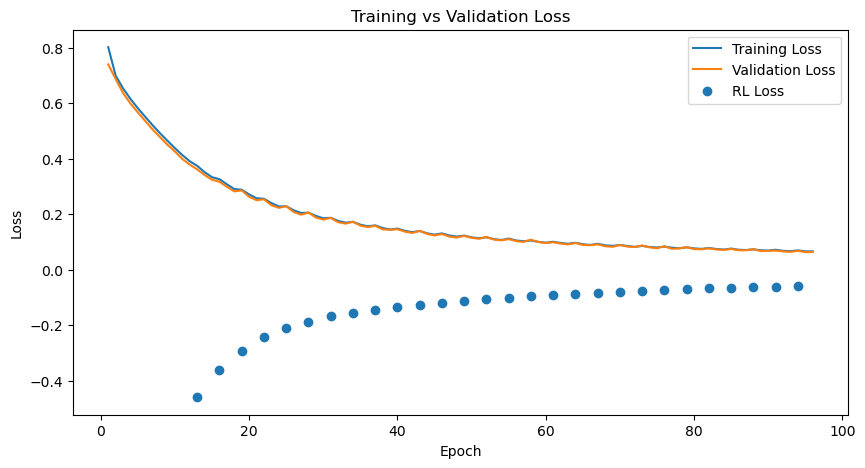

In [14]:

epochs = range(1, len(all_train_loss) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, all_train_loss, label='Training Loss')
plt.plot(epochs, all_val_loss, label='Validation Loss')
plt.scatter(range(start_epoch, start_epoch+len(all_avg_rewards)), all_avg_rewards, label='RL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [15]:
import datetime

tz = datetime.timezone.utc
ft = "%Y_%m_%d_%H_%M_%S_%z"
t = datetime.datetime.now(tz=tz).strftime(ft)
# print(t)

CKPT_FILE_NAME = f'PPG_PEAK_DETECTION_MODEL_{epoch}_{t}.pth'
CKPT_FILE = os.path.join('../trained_model',CKPT_FILE_NAME)
print(CKPT_FILE)
# save weights
torch.save(model.state_dict(), CKPT_FILE)
print('Checkpoint saved.')


../trained_model/PPG_PEAK_DETECTION_MODEL_97_2025_04_22_19_48_06_+0000.pth
Checkpoint saved.


In [26]:
FOLDER_PATH = 'length_full'
TEST_PATH = os.path.join('../data','processed',FOLDER_PATH,'test_ds.h5')  # update if your file lives elsewhere

CKPT     = os.path.join('../trained_model/checkpoints/',f'ckpt_epoch_nn_w_rl2_{85}.pth')
if not os.path.exists(TEST_LOADER_PATH):
    test_ds = PPGWindow(TEST_PATH,best_config=best_config,scale_type=scale_type)
    torch.save(test_ds,TEST_LOADER_PATH)
else:
    test_ds = torch.load(TEST_LOADER_PATH,weights_only=False)

test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=False)

# ------------ load the trained model -------------------------------------
model  = UNet1D().to(device)
ckpt = torch.load(CKPT, map_location=device)
model.load_state_dict(ckpt["model"])
model.eval()



UNet1D(
  (downs): ModuleList(
    (0): ConvBlock(
      (net): Sequential(
        (0): Conv1d(1, 16, kernel_size=(9,), stride=(1,), padding=(4,))
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv1d(16, 16, kernel_size=(9,), stride=(1,), padding=(4,))
        (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): ConvBlock(
      (net): Sequential(
        (0): Conv1d(16, 32, kernel_size=(9,), stride=(1,), padding=(4,))
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,))
        (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvBlock(
      (net): Sequential(
        (0): Co

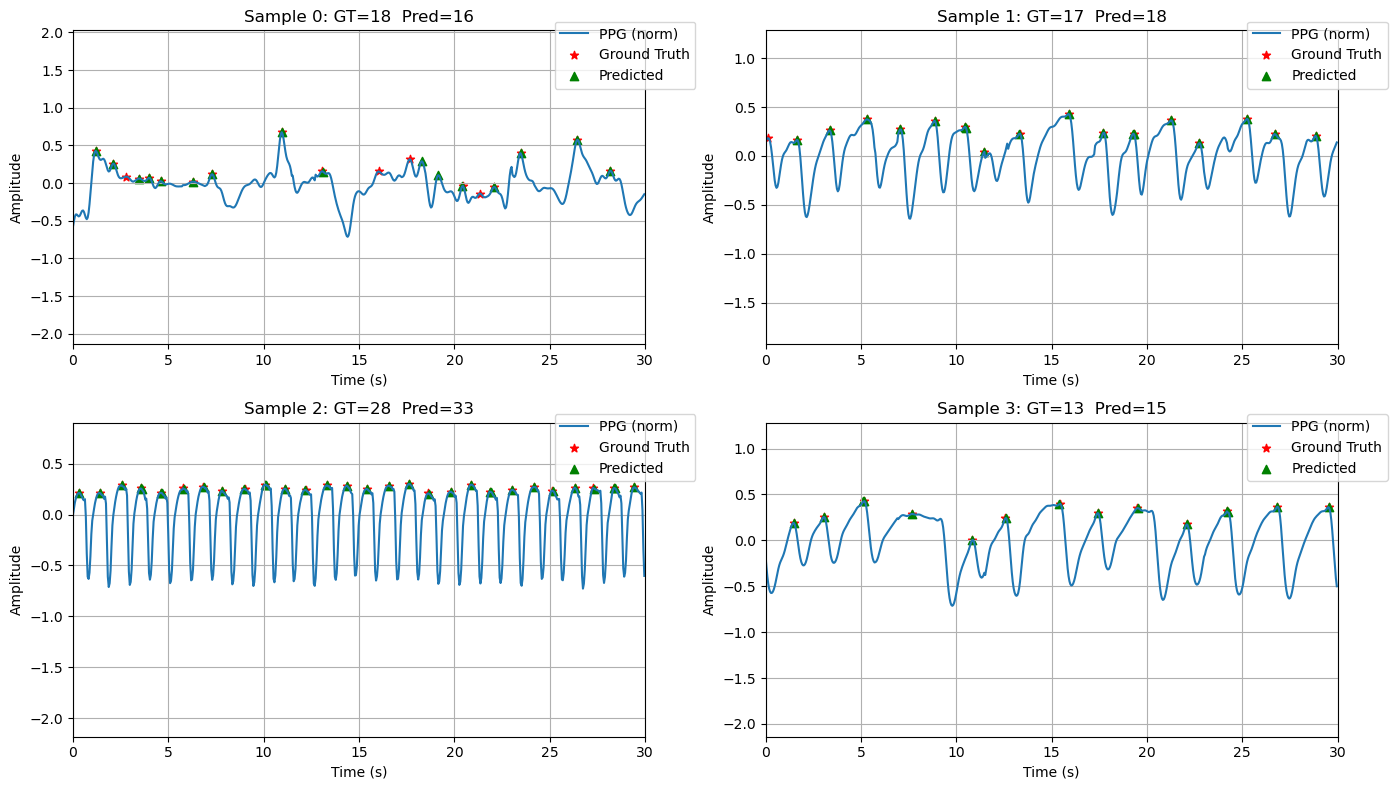

In [28]:
THRESH   = 0.7         # probability cut‑off for “peak”
xb, yb, orig,_ = next(iter(test_loader))     # xb: (B,1,L), yb: (B,L), orig:(B,1,L)
xb, yb, orig = xb.to(device), yb.to(device), orig  # orig can stay on CPU

yb_cpu = yb.cpu().numpy()          # shape (B, L)

B, _, L = xb.shape
t = np.arange(L) / FS  # common time axis, shape (L,)
# print(t)
# How many to plot

n_plot = min(4, B)
cols   = math.ceil(math.sqrt(n_plot))
rows   = math.ceil(n_plot / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*7, rows*4), squeeze=False)

# fig2, axes2 = plt.subplots(rows, cols, figsize=(cols*7, rows*4), squeeze=False)

for i in range(n_plot):
    ax = axes[i//cols][i%cols]
    # ax1 = axes2[i//cols][i%cols]
    # 1) model forward only this window
    
    # 1) raw 625‐point window
    original_window = orig[i,0].numpy()   # shape (L,)
    # if you had inverted sign elsewhere:
    original_window = -original_window

    # 2) normalized window
    window_norm = xb[i,0].cpu().numpy()   # shape (L,)
    # if you invert:
    window_norm = -window_norm

    # 3) model prediction for this window
    inp  = xb[i:i+1].to(device)            # shape (1,1,L)
    # print(inp)   
    with torch.no_grad():
        prob = torch.sigmoid(model(inp))[0]  # shape (L,)
    prob_np    = prob.cpu().numpy()
    peaks_pred = np.where(prob_np > THRESH)[0]

    # 4) ground‑truth peaks from yb
    gt_peaks = np.where(yb_cpu[i] > 0)[0]
    # 5) now plot
    # ax.plot(t, original_window, label='PPG (raw)', alpha=0.7)
    ax.plot(t, window_norm,label='PPG (norm)', linestyle='-')
    ax.scatter(t[gt_peaks], window_norm[gt_peaks],
               c='r', marker='*', label='Ground Truth')
    ax.scatter(t[peaks_pred], window_norm[peaks_pred],
               c='g', marker='^', label='Predicted')


    ax.set_title(f"Sample {i}: GT={len(gt_peaks)}  Pred={len(peaks_pred)}")
    ax.set_xlim(0, WIN_SEC)
    ax.set_ylim(np.min(window_norm)*3, np.max(window_norm)*3)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.legend(loc='upper right',bbox_to_anchor=(1.1, 1.05))
    ax.grid()


    # ax1.hist(np.diff(t[peaks_pred]))

plt.tight_layout()
plt.show()

In [29]:

print('Ground Truth Peak Positions: \t', gt_peaks)
print('Predicted Peaks Positions: \t', peaks_pred)
print(len(gt_peaks[1:] - gt_peaks[:-1]))
print(len(peaks_pred[1:] - peaks_pred[:-1]))


Ground Truth Peak Positions: 	 [ 31  64 108 160 226 262 322 363 406 460 504 559 615]
Predicted Peaks Positions: 	 [ 31  64 107 108 160 226 263 321 363 407 460 504 505 559 615]
12
14


In [ ]:
model.eval()
all_test_loss = [];
cumulative_test_loss = 0.0
with torch.no_grad():
    for xb, yb,_,_ in tqdm(test_loader, desc=f'Test\t | Epoch {epoch+1}/{EPOCHS}'):
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        with torch.autocast("mps", dtype=torch.bfloat16):
            logits = model(xb).float()
            test_loss   = criterion(logits, yb)
        if torch.isnan(validation_loss): raise ValueError('NaN loss')
        cumulative_test_loss += validation_loss.item() * xb.size(0)

mean_val = cumulative_test_loss / (len(test_loader.dataset))
all_test_loss.append(mean_val)

Val	 | Epoch 98/200: 100%|██████████| 110/110 [02:16<00:00,  1.24s/it]


In [31]:
print(all_test_loss)

[0.06612946838140488]
